
# TipTop — Asterism Selection: Hands‑on Tutorial (VS Code / Jupyter)

This notebook shows how to run **asterismSelection** with **TipTop**, inspect and save metrics, reload results later without recomputing, and (optionally) train a heuristic model for fast ranking.

**Mono** (ERIS) vs. **Multi** (MAVIS)
- ERIS (mono): 1 star per asterism
- MAVIS (multi): 3 stars per asterism 

**What you'll learn**
1. Point **TipTop** to an `.ini` file with `[ASTERISM_SELECTION]`.
2. Run `tiptop.asterismSelection(...)` and interpret outputs.
3. Rank and print the **best asterism per field** (with optionnal JSON export).
4. Run `tiptop.overallSimulation(...)` on the global best asterism.
5. Reload metrics later via **reloadAsterismSelection(...)** (no recomputation).
6. (Optional) Train/test a **heuristic model** for fast ranking (splines for mono, NN for multi).

**What this notebook saves**
- Arrays/metrics in your `OUTPUT_DIR`.
- Optional **JSON** snapshots of the best (or all) asterisms, including the star inputs (_zenith, azimuth, photons, freq_)
- Optional heuristic model files (`.npy`/ `.pth`) when training is enabled.



## 0) Prerequisites

- Python 3.11+ recommended
- `astro-tiptop` version 1.3.25 or higher

In [15]:
# Check environment
import os, sys, platform, time, json
print('Python:', sys.version.split()[0], '| Platform:', platform.platform())
print('CWD   :', os.getcwd())

Python: 3.12.3 | Platform: Windows-11-10.0.26100-SP0
CWD   : c:\Users\lmazzolo\Documents\PRO\SAND_BOX\asterism_tests



## 1) Choose your configuration

Set the variables below to point to one of your `.ini` files in `astTest/` (or elsewhere).
Examples shipped with your project include:
- ERIS (mono)
    - `ERISast10.ini` - mode = `FileMono`
    - `ERISastSingles1.ini` - mode = `Singles1`
    - `ERISastRandom.ini` - mode = `FileRandomMono`
- MAVIS (multi)
    - `MAVISast.ini` - mode = `File`
    - `MAVISastSingles.ini` - mode = `Singles3`

**Note**. `ERISastSingles1.ini` requires a pre-generated heuristic model, because the INI already references one: `heuristicModel = 'ERISast_hmodel'`.

In [16]:
from pathlib import Path

# === EDIT ME (or run as-is if you keep the suggested defaults) ===
SIMUL_NAME   = "ERIStest"            # short name used as prefix for outputs
PARAMS_DIR   = "astTest" # folder containing your .ini files 
INI_BASENAME = "ERISast10"             # file name *without* .ini extension
OUTPUT_DIR   = "outputs"             # where arrays/PNGs will be written
GPU_INDEX    = 0                     # choose target GPU if relevant

# Create output dir if missing
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

print('Using configuration:')
print('  SIMUL_NAME  =', SIMUL_NAME)
print('  PARAMS_DIR  =', PARAMS_DIR)
print('  INI_BASENAME=', INI_BASENAME)
print('  OUTPUT_DIR  =', OUTPUT_DIR)

Using configuration:
  SIMUL_NAME  = ERIStest
  PARAMS_DIR  = astTest
  INI_BASENAME= ERISast10
  OUTPUT_DIR  = outputs



### (Optional) List available `.ini` files


In [17]:
from pathlib import Path
p = Path(PARAMS_DIR)
if not p.exists():
    print(f"[WARN] The folder {p} does not exist in your current working directory.")
else:
    print('INI files under', p.resolve())
    for ini in sorted(p.glob('*.ini')):
        print(' -', ini.name)

INI files under C:\Users\lmazzolo\Documents\PRO\SAND_BOX\asterism_tests\astTest
 - ERISast.ini
 - ERISast10.ini
 - ERISast100.ini
 - ERISast1000.ini
 - ERISastMonads.ini
 - ERISastRandom.ini
 - ERISastSingles1.ini
 - MAVISast.ini
 - MAVISastGenerate.ini
 - MAVISastSingles.ini
 - MAVISastTriplets.ini


## 2) Run the asterism selection

This cell calls **`tiptop.asterismSelection(...)`** using your chosen INI.  
Outputs (arrays) are saved into `OUTPUT_DIR`, and a `simulation` object is returned for further inspection.


In [18]:
import numpy as np
from time import perf_counter

try:
    from tiptop.tiptop import asterismSelection
except Exception as e:
    raise SystemExit("Could not import 'tiptop'. Install it first (pip install astro-tiptop).\n" + str(e))

t0 = perf_counter()
sr, fw, ee, covs, simul = asterismSelection(simulName=SIMUL_NAME, path2param=PARAMS_DIR,
                                            parametersFile=INI_BASENAME, outputDir=OUTPUT_DIR,
                                            outputFile='psf', doPlot=False,
                                            returnRes=False, returnMetrics=True,
                                            addSrAndFwhm=True, verbose=False,
                                            getHoErrorBreakDown=False, ensquaredEnergy=False,
                                            eeRadiusInMas=50, doConvolve=False,
                                            plotInComputeAsterisms=False, progressStatus=False,
                                            gpuIndex=GPU_INDEX)
t1 = perf_counter()

print(f"Done in {t1 - t0:.1f} s")

Number of Fields: 10

total_skipped_fields:  0
total_skipped_asterisms:  0
total good asterisms:  39
simpleVarianceComputation method is deprecated, it will not be used!
simpleVarianceComputation method is deprecated, it will not be used!
simpleVarianceComputation method is deprecated, it will not be used!
simpleVarianceComputation method is deprecated, it will not be used!
simpleVarianceComputation method is deprecated, it will not be used!
simpleVarianceComputation method is deprecated, it will not be used!
simpleVarianceComputation method is deprecated, it will not be used!
simpleVarianceComputation method is deprecated, it will not be used!
simpleVarianceComputation method is deprecated, it will not be used!
simpleVarianceComputation method is deprecated, it will not be used!
Done in 9.9 s



## 3) Summarize per field + (optional) JSON export 
This step produces a quick, human-readable summary and (optionally) a JSON snapshot you can reuse (dashboards, API mocks, sharing).

### What it does
- Uses the in-memory metrics (sr, fwhm, ee, penalty).
- For each field, finds the **best asterism** (lowest jitter/penalty).
- Prints a compact line: penalty, SR, FWHM, EE (reduced to scalars for readability).
- Optionally writes a JSON file:
    - `include_all=False` → only the best asterism per field (`best_by_field`).
    - `include_all=True` → all asterisms, globally sorted by penalty (ascending).

### Multi-mode note (e.g., MAVIS)
FWHM (and parfois EE) can be an array per asterism (several science points).
The  `reduce=` option controls how we turn that array into a single number for printing and the `metrics` block in the JSON:
- `"mean"` (default): average across positions
- `"median"`: robust central tendency
- `"first"`: just take the first value (useful for quick checks)

**Precision & size trade-offs:** `round_ndigits=5` keeps the JSON light. Use `None` for full precision.

In [19]:
import os, json, numpy as np
from dataclasses import asdict, is_dataclass

# --- JSON-safe conversion + rounding --------------------------------
def _to_builtin(obj):
    if isinstance(obj, np.generic):
        return obj.item()
    if is_dataclass(obj):
        from dataclasses import asdict
        return _to_builtin(asdict(obj))
    if isinstance(obj, dict):
        return {k: _to_builtin(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [_to_builtin(x) for x in obj]
    if isinstance(obj, np.ndarray):
        return _to_builtin(obj.tolist())
    return obj

def _round_nums(obj, ndigits=None):
    if ndigits is None:
        return obj
    if isinstance(obj, float):
        return round(obj, ndigits)
    if isinstance(obj, dict):
        return {k: _round_nums(v, ndigits) for k, v in obj.items()}
    if isinstance(obj, list):
        return [_round_nums(v, ndigits) for v in obj]
    return obj

def _star_list_from_simul(simul, idx):
    """Return [{'zenith', 'azimuth', 'photons', 'freq'}, ...] for asterism idx."""
    P = getattr(simul, 'asterismsInputDataPolar', None)
    if P is None or idx >= len(P):
        return []
    block = np.asarray(P[idx])     # shape expected: (4, nGS)
    if block.ndim != 2 or block.shape[0] != 4:
        # fallback: try to coerce
        block = np.reshape(block, (4, -1))
    zen, az, pho, fr = (np.ravel(block[0]), np.ravel(block[1]),
                        np.ravel(block[2]), np.ravel(block[3]))
    stars = []
    for z, a, p, f in zip(zen, az, pho, fr):
        stars.append({
            "zenith": float(z),
            "azimuth": float(a),
            "photons": float(p),
            "freq":   float(f),
        })
    return stars

def _reduce_metric(x, how="mean"):
    """
    x can be scalar, 1D, 2D, etc. Returns a float.
    how: "mean" | "median" | "first"
    """
    arr = np.asarray(x, dtype=float)
    if arr.size == 0 or not np.isfinite(arr).any():
        return None
    if how == "first":
        return float(arr.ravel()[0])
    if how == "median":
        return float(np.nanmedian(arr))
    return float(np.nanmean(arr))  # default: mean

def _one_ast_dict(simul, idx, sr, fw, penalty, reduce="mean"):

    """Build a dict for a given asterism (global index)."""
    sr_v = None if sr is None else _reduce_metric(sr[idx], how=reduce)
    fw_v = None if fw is None else _reduce_metric(fw[idx], how=reduce)
    pj_v = None if penalty is None else _reduce_metric(penalty[idx], how="first")
    return {
        "index": int(idx),
        "stars": _star_list_from_simul(simul, idx),
        "metrics": {
            "jitter": pj_v,
            "strehl": sr_v,
            "fwhm": fw_v,
        },
    }

# --- summarize with optional JSON export -------------------------------------
def summarize(simul, sr, fw, outdir: str, simul_name: str,
              save_json: bool = False,
              json_path: str | None = None,
              round_ndigits: int | None = 5,
              include_all: bool = False,
              reduce: str = "mean"):
    """
    Affiche un résumé par champ (meilleur asterism par jitter croissant).
    Optionnel: écrit un JSON soit avec les meilleurs par champ, soit tous les asterisms triés.
    """
    penalty = getattr(simul, 'penalty_Asterism', None)
    cum     = getattr(simul, 'cumAstSizes', None)
    nfields = getattr(simul, 'nfields', None)

    print('\n=== METRICS SHAPES ===')
    print('  SR :', None if sr is None else np.shape(sr))
    print('  FWHM:', None if fw is None else np.shape(fw))

    if cum is None or penalty is None or nfields is None:
        print('\n[WARN] Missing cumAstSizes/penalty_Asterism/nfields — per-field ranking skipped.')
        return

    os.makedirs(outdir, exist_ok=True)
    print(f"\nFields: {nfields}")

    best_items = []  # for "best_by_field" JSON

    for f in range(nfields):
        i0, i1 = int(cum[f]), int(cum[f+1])
        if i1 <= i0:
            print(f"Field {f:03d}: empty range")
            continue

        local_pen = np.asarray(penalty[i0:i1], dtype=float).ravel()
        try:
            jbest_local = int(np.nanargmin(local_pen))
            best_index = i0 + jbest_local
        except ValueError:
            # Fallback to SR if penalty is NaN-only
            if sr is None:
                print(f"Field {f:03d}: cannot rank (no metrics).")
                continue
            jbest_local = int(np.nanargmax(np.asarray(sr[i0:i1]).astype(float)))
            best_index = i0 + jbest_local

        # --- Display (reduce metrics to scalars first)
        pj_v = None if penalty is None else _reduce_metric(penalty[best_index], how="first")
        sr_v = None if sr      is None else _reduce_metric(sr[best_index], how=reduce)
        fw_v = None if fw      is None else _reduce_metric(fw[best_index], how=reduce)

        msg = f"Field {f:03d} → best asterism (global index={best_index})"
        parts = []
        if pj_v is not None and np.isfinite(pj_v): parts.append(f"penalty={pj_v:.4g}")
        if sr_v is not None and np.isfinite(sr_v): parts.append(f"SR={sr_v:.4g}")
        if fw_v is not None and np.isfinite(fw_v): parts.append(f"FWHM={fw_v:.4g}")
        if parts: msg += " [" + ", ".join(parts) + "]"
        print(msg)

        # Accumulate for the JSON best_by_field output
        best_items.append({
            "field": int(f),
            **_one_ast_dict(simul, best_index, sr, fw, penalty, reduce=reduce)
        })

    # --- Optional JSON writing ------------------------------------------------
    if save_json:
        if json_path is None:
            base = f"{simul_name}_{'all' if include_all else 'best'}_asterisms.json"
            json_path = os.path.join(outdir, base)

        # Build payload
        payload = {
            "simul_name": simul_name,
            "nfields": int(nfields),
        }

        if include_all:
            # Global sort by increasing penalty
            pen = np.asarray(penalty).reshape(-1)
            order = np.argsort(pen)  # NaNs go last; if needed: np.argsort(np.nan_to_num(pen, nan=np.inf))
            all_items = [_one_ast_dict(simul, int(i), sr, fw, penalty, reduce=reduce) for i in order]
            payload["asterisms"] = all_items
        else:
            payload["best_by_field"] = best_items

        # Make JSON-safe + round floats
        payload = _round_nums(_to_builtin(payload), round_ndigits)

        os.makedirs(os.path.dirname(json_path), exist_ok=True)
        with open(json_path, "w", encoding="utf-8") as f:
            json.dump(payload, f, ensure_ascii=False, indent=2)
        print("📝 JSON saved:", json_path)

In [20]:
# --- Example call -------------------------------------------------------------
summarize(simul, sr, fw, outdir=OUTPUT_DIR, simul_name=SIMUL_NAME,
           save_json=True, json_path=None, round_ndigits=5, include_all=True, reduce= "mean")


=== METRICS SHAPES ===
  SR : (39, 1)
  FWHM: (39, 1, 1)

Fields: 10
Field 000 → best asterism (global index=2) [penalty=218.2, SR=0.5014, FWHM=48.49]
Field 001 → best asterism (global index=7) [penalty=407.1, SR=0.09045, FWHM=76.38]
Field 002 → best asterism (global index=12) [penalty=253.1, SR=0.3951, FWHM=53.25]
Field 003 → best asterism (global index=16) [penalty=1079, SR=4.628e-08, FWHM=187.9]
Field 004 → best asterism (global index=18) [penalty=288.5, SR=0.299, FWHM=58.33]
Field 005 → best asterism (global index=23) [penalty=439, SR=0.06116, FWHM=81.43]
Field 006 → best asterism (global index=26) [penalty=482.5, SR=0.0342, FWHM=88.39]
Field 007 → best asterism (global index=29) [penalty=259.9, SR=0.3754, FWHM=54.22]
Field 008 → best asterism (global index=33) [penalty=602.6, SR=0.005163, FWHM=108]
Field 009 → best asterism (global index=36) [penalty=448.7, SR=0.05399, FWHM=82.97]
📝 JSON saved: outputs\ERIStest_all_asterisms.json


## 4) Run `tiptop.overallSimulation` on the best asterism
**Goal**. Re-run a full simulation on a **single asterism**: the global best (minimum jitter/penalty) across all fields combined, starting from exactly the same INI baseline as in step 1.

### What this cell does
- Reloads (or reuses) the results from step 2.
- Selects the **global** best asterism with the lowest penalty.
- Copies the base INI and injects the chosen NGS asterism into `sources_LO` / `sensor_LO` / `RTC`.
- Removes the `[ASTERISM_SELECTION]` section to switch to “single-asterism” mode.
- Calls `overallSimulation`.

**Note**. For demonstration purposes, this notebook picks **one global** best among all fields.
If you need one best asterism per field, iterate over the field ranges and select each field’s minimum penalty.

In [21]:
# === Use the base INI from step 1 ====================
import os, tempfile
from configparser import ConfigParser
import numpy as np
from tiptop.tiptop import overallSimulation

# --- Reuse outputs from step 2 (no recomputation) -----------------
# Prefer in-memory variables from step 2; otherwise, reload from disk via `reloadAsterismSelection`.
try:
    _ = (sr, fw, simul)  # checks that the variables exist
    print("✅ Reusing step-2 metrics (in memory)..")
except NameError:
    try:
        from tiptop.tiptop import reloadAsterismSelection
    except Exception as _e:
        raise SystemExit("⚠️ Neither in-memory outputs nor reload is possible. "
                         "Please run step 2 at least once.\n" + str(_e))
    print("ℹ️ Step-2 outputs not found in memory — reloading from disk…")
    sr, fw, ee, covs, simul = reloadAsterismSelection(
        simulName=SIMUL_NAME, path2param=PARAMS_DIR,
        parametersFile=INI_BASENAME, outputDir=OUTPUT_DIR,
        outputFile='psf', returnMetrics=True
    )

def pick_best_asterism_global(simul) -> int:
    """Best index by minimal penalty."""
    pen = np.asarray(simul.penalty_Asterism).reshape(-1)
    return int(np.nanargmin(pen))

def extract_polar_stars(simul, ast_global_index):
    """Extract [zenith, azimuth, photons, freq] lists for a given global asterism index."""
    block = np.asarray(simul.asterismsInputDataPolar[ast_global_index])  # shape (4, nGS)
    z  = [float(v) for v in np.atleast_1d(block[0]).tolist()]
    a  = [float(v) for v in np.atleast_1d(block[1]).tolist()]
    ph = [float(v) for v in np.atleast_1d(block[2]).tolist()]
    fr = [float(v) for v in np.atleast_1d(block[3]).tolist()]
    return z, a, ph, fr

def write_ini_from_base_minimal(base_dir: str, base_name_no_ext: str,
                                z_list, a_list, ph_list, fr_list,
                                out_dir: str, new_name_no_ext: str) -> str:
    """
    Load the exact INI used in step 1, remove [ASTERISM_SELECTION], and inject the chosen asterism.
    Only these keys are changed:
      - sources_LO.Zenith / Azimuth
      - sensor_LO.NumberPhotons
      - RTC.SensorFrameRate_LO
    """
    base_path = os.path.join(base_dir, f"{base_name_no_ext}.ini")

    cfg = ConfigParser()
    cfg.optionxform = str  # preserve key case
    with open(base_path, "r", encoding="utf-8") as f:
        cfg.read_file(f)

    # Remove the scan section if present
    if cfg.has_section("ASTERISM_SELECTION"):
        cfg.remove_section("ASTERISM_SELECTION")

    # Ensure sections exist (usually they already exist in your base INI)
    for sec in ("sources_LO", "sensor_LO", "RTC"):
        if not cfg.has_section(sec):
            cfg.add_section(sec)

    # nGS must be consistent across lists
    z_list = list(map(float, z_list))
    a_list = list(map(float, a_list))
    ph_list = list(map(float, ph_list))
    fr_list = list(map(float, fr_list))
    n_gs = {len(z_list), len(a_list), len(ph_list), len(fr_list)}
    assert len(n_gs) == 1, f"Inconsistent NGS lengths: {n_gs}"

    # Write only the four LO keys; keep everything else from the base INI
    cfg.set("sources_LO", "Zenith",  repr(z_list))
    cfg.set("sources_LO", "Azimuth", repr(a_list))
    cfg.set("sensor_LO", "NumberPhotons", repr(ph_list))
    cfg.set("RTC",       "SensorFrameRate_LO", repr(fr_list))

    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f"{new_name_no_ext}.ini")
    with open(out_path, "w", encoding="utf-8") as f:
        cfg.write(f)
    print("📝 Wrote INI (minimal):", out_path)
    return out_path

# ---- Choose best asterism and run overallSimulation ------------------------
best_idx = pick_best_asterism_global(simul)
z,a,ph,fr = extract_polar_stars(simul, best_idx)

# IMPORTANT: set these two to the SAME values you used in step 1
# (path to the directory containing your original .ini, and its basename without .ini)
BASE_DIR   = PARAMS_DIR
BASE_NAME  = INI_BASENAME

tmp_dir = tempfile.mkdtemp(prefix="tiptop_best_")
NEW_NAME = f"{BASE_NAME}_best_ast"
ini_path = write_ini_from_base_minimal(BASE_DIR, BASE_NAME, z, a, ph, fr, tmp_dir, NEW_NAME)

# Run the single-asterism full simulation
overallSimulation(tmp_dir, NEW_NAME, OUTPUT_DIR, f"{SIMUL_NAME}_best",
                                  returnMetrics=False, verbose=False)

print("✅ overallSimulation done.")
print("Best asterism global index:", best_idx)

✅ Reusing step-2 metrics (in memory)..
📝 Wrote INI (minimal): C:\Users\lmazzolo\AppData\Local\Temp\tiptop_best_h6lc0o6f\ERISast10_best_ast.ini
simpleVarianceComputation method is deprecated, it will not be used!
✅ overallSimulation done.
Best asterism global index: 2


### Read the metrics written by `overallSimulation` (from the FITS)

In [22]:
from astropy.io import fits
import os

fits_path = os.path.join(OUTPUT_DIR, f"{SIMUL_NAME}_best.fits")
if not os.path.exists(fits_path):
    raise FileNotFoundError(f"FITS file not found: {fits_path}")

hdul = fits.open(fits_path)
hdr = hdul[1].header
data = hdul[1].data

n_psf = data.shape[0]
wvl = float(hdr.get("WL_NM"))       # Wavelength in nm
pix_mas = float(hdr.get("PIX_MAS")) # Pixel scale in milliarcseconds

sr_list   = [hdr.get(f"SR{k:04d}")   for k in range(n_psf)]
fwhm_list = [hdr.get(f"FWHM{k:04d}") for k in range(n_psf)]

print(f"File: {fits_path}")
print(f"WL_NM={wvl:.0f} nm | PIX_MAS={pix_mas:.2f} mas/px | n_psf={n_psf}")
print("SR per PSF  :", sr_list)
print("FWHM per PSF:", fwhm_list, "(mas)")
hdul.close()

File: outputs\ERIStest_best.fits
WL_NM=1650 nm | PIX_MAS=14.00 mas/px | n_psf=1
SR per PSF  : [0.50135]
FWHM per PSF: [47.295] (mas)


### Visualize the AO PSFs (grid + SR/FWHM labels)

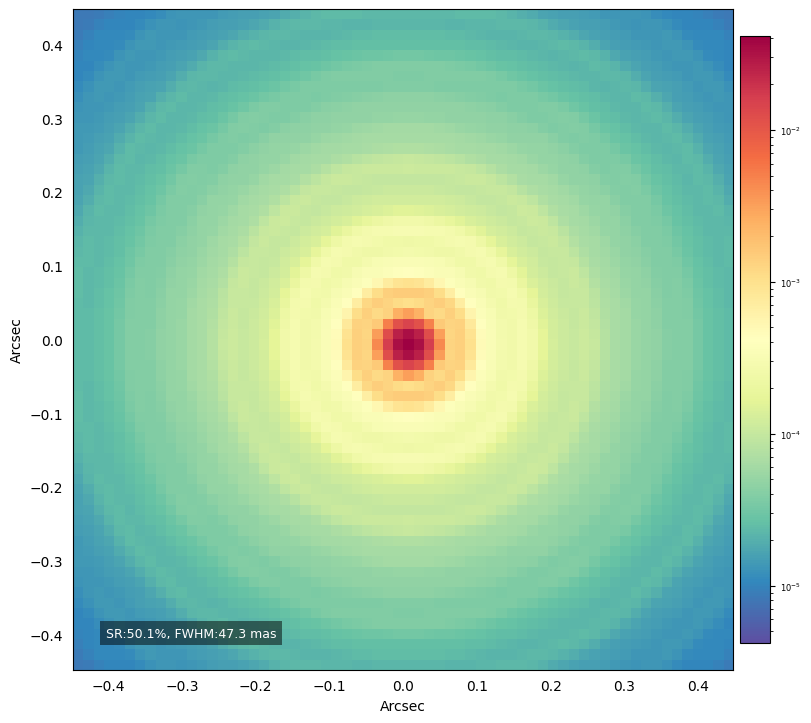

In [23]:
# === Visualize AO PSFs written by overallSimulation ===
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Try to import cropSupport; otherwise provide a simple fallback
try:
    from p3.aoSystem.FourierUtils import cropSupport
except Exception:
    def cropSupport(img, factor_or_size):
        """
        Fallback: center-crop to a square of size N/factor if int factor,
        or to 'factor_or_size' if it looks like a pixel size.
        """
        arr = np.asarray(img)
        n   = arr.shape[0]
        if isinstance(factor_or_size, int) and factor_or_size > 1:
            size = max(4, n // factor_or_size)
        else:
            size = int(factor_or_size)
        c = n // 2
        h = size // 2
        return arr[c - h:c + h, c - h:c + h]


# How many PSFs to display (largest square ≤ n_psf)
max_display = int(np.floor(np.sqrt(n_psf))) ** 2  
n_rows = int(np.sqrt(max_display))
n_cols = n_rows

# Crop parameters and axes (arcsec)
crop_size = 4
nx = cropSupport(data[0], crop_size).shape[0]
axis = np.linspace(-nx//2, nx//2, nx) * pix_mas * 1e-3

fig, axs = plt.subplots(n_rows, n_cols, figsize=(8, 8), constrained_layout=True, squeeze=False)
for i in range(max_display):
    ax = axs.flat[i]
    img = ax.imshow(cropSupport(data[i], crop_size),
                    cmap='Spectral_r',
                    extent=[axis[0], axis[-1], axis[0], axis[-1]],
                    norm=mcolors.LogNorm(vmin=np.max(data)*1e-4, vmax=np.max(data)))
    ax.text(0.05, 0.05,
         f'SR:{sr_list[i]*100:.1f}%, FWHM:{fwhm_list[i]:.1f} mas',
         color='white', fontsize=9, transform=ax.transAxes,
         bbox=dict(facecolor='black', alpha=0.5, lw=0))
    if i % n_cols == 0:
        ax.set_ylabel('Arcsec', fontsize=10)
    else:
        ax.set_yticks([])
    if i // n_cols == n_rows - 1:
        ax.set_xlabel('Arcsec', fontsize=10)
    else:
        ax.set_xticks([])
    # Set tick parameters
    ax.tick_params(labelsize=10, color='white')
    # Add a small colorbar to the right of each subplot
    cbar = plt.colorbar(img, ax=ax, fraction=0.046, pad=0.01)
    cbar.ax.tick_params(labelsize=6)


## 4) Reload previously computed metrics
Use this helper when you only need the arrays (e.g., for a dashboard or after a long run).

**Goal**. Bring the arrays (`sr`, `fwhm`, `ee`, `covs`) and a lightweight simulation object back into memory without rerunning the AO engine.


In [24]:
try:
    from tiptop.tiptop import reloadAsterismSelection
except Exception as e:
    raise SystemExit('Install tiptop first: pip install astro-tiptop\n' + str(e))

sr, fw, ee, covs, simul = reloadAsterismSelection(simulName=SIMUL_NAME, path2param=PARAMS_DIR,
                                                  parametersFile=INI_BASENAME, outputDir=OUTPUT_DIR,
                                                  outputFile='psf', doPlot=False,
                                                  returnRes=False, returnMetrics=True,
                                                  addSrAndFwhm=True, verbose=False,
                                                  getHoErrorBreakDown=False, ensquaredEnergy=False,
                                                  eeRadiusInMas=50, gpuIndex=GPU_INDEX)

print('Reloaded arrays:', 
      'SR' if sr is not None else '-', 
      'FW' if fw is not None else '-', 
      'EE' if ee is not None else '-')

Number of Fields: 10

total_skipped_fields:  0
total_skipped_asterisms:  0
total good asterisms:  39
Reloaded arrays: SR FW EE



## 5) (Optional) Train & test a heuristic model
**Goal**. Learn a fast surrogate that can rank asterisms without running the full AO simulation each time.
- Mono (ERIS) → spline-based model
- Multi (MAVIS) → small neural network

### What this cell does
- Ensures asterism metrics exist (computes or reloads them internally).
- Splits data into train/test (default `share=0.9` → 90% train, 10% test).
- Trains the model and, if `doTest=Tru`e, reports accuracy and ranking quality.
- Saves a model file (typically under `OUTPUT_DIR`) named like `<INI_BASENAME>_hmodel.npy` (mono) or `.pth` (multi).

In [25]:
# Enable training only when there are enough asterisms to learn from.
# For now, this INI is the only one that reliably produces sufficient samples
# (random/synthetic). If another configuration meets the threshold, update the check.
DO_TRAIN = True  # set True to run training
if INI_BASENAME in ("ERISastRandom", "ERISast"):
    if DO_TRAIN:
        try:
            from tiptop.tiptop import generateHeuristicModel
        except Exception as e:
            raise SystemExit('Install tiptop first: pip install tiptop\n' + str(e))

        simul_h = generateHeuristicModel(simulName=SIMUL_NAME, path2param=PARAMS_DIR,
                                        parametersFile=INI_BASENAME, outputDir=OUTPUT_DIR,
                                        outputFile='psf', doPlot=False, doTest=False,
                                        share=0.9, eeRadiusInMas=50, gpuIndex=GPU_INDEX)
        print('Heuristic model generated. You can now set heuristicModel in the INI to reuse it.')

### How to reuse the model
Add the path to your INI so subsequent `asterismSelection(...)` runs can skip the heavy AO step and rank instantly:

In [ ]:
[ASTERISM_SELECTION]
heuristicModel = outputs/ERISast_hmodel.pth  ; or MAVIS..._hmodel.npy

### Inputs to keep consistent
Use the same `SIMUL_NAME`, `PARAMS_DIR`, `INI_BASENAME`, and `OUTPUT_DIR` you used for your asterism run so the trainer can find the data it needs.

### Notes & tips
- `eeRadiusInMas` should match how you computed/expect EE in your metrics.
- You need enough asterisms to train (dozens at least; the more the better).
- Models are not portable across different system configs/instruments—train per setup.